## Deep Learning training with GRU and an extended FastText word embedding
We test here the combination of:
* an embedding layer which is initialized with a pretrained fasttext word embedding extended with custom embedding model
* a GRU (Gated Recurrent Unit) layer to capture word sequence representation
* a dense layer to learn classification

We leverage the pre-trained fasttext word embedding model gracefully supplied by Facebook company at [https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)

This general purpose word embedding model is extended with custom model generated by [fasttext_embedding_extension_builder.ipynb](fasttext_embedding_extension_builder.ipynb) script

In [5]:
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
from utils import vizu
from utils import serializer

embeddings_index = {}

In [6]:
from sklearn.model_selection import train_test_split

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('../../data/POSOS/label.csv', sep=';')

XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size=0.15, random_state=42)


###  <b>Build neural network with GRU and FastText embedding<b>

In [7]:
# hyper-parameters
num_classes = 51
vocabulary_size = 10000
sequence_length = 30
embedding_out_dims = 300
dropout_ratio = 0.15
num_epochs = 200
hidden_dims = 200
patience = 50

In [8]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(XTrain['question'])

sequences = tokenizer.texts_to_sequences(XTrain['question'])
XEncodedTrain = pad_sequences(sequences, maxlen=sequence_length, truncating='pre')

In [9]:
# load the French fasttext model
import os, re, csv, math, codecs
from tqdm import tqdm

if len(embeddings_index) == 0:
    
    f = codecs.open('../../pretrained_models/fasttext/wiki.fr.vec', encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

1152466it [02:33, 7527.16it/s]


In [10]:
# complete the embedding mode with the custom one built by the script additional_fasttext_embedding_builder.ipynb
customEmbedding = serializer.loadEmbeddingVector('../../pretrained_models/fasttext_embedding_extension.txt')

for k,v in customEmbedding.items():
    embeddings_index[k] = v    

In [11]:
nb_words = min(vocabulary_size, len(tokenizer.word_index))

embedding_matrix = np.zeros((nb_words+1, embedding_out_dims))

for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
                
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        raise Exception("unknown word=" + word)

In [12]:
import tensorflow as tf
import keras
from keras.layers import CuDNNGRU
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
#config = tf.ConfigProto(device_count={"CPU": 32})

# configure tensorflow
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7, allow_growth = True)
config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# build neural network
model_lstm = Sequential()

# dimension reduction layer
model_lstm.add(
    Embedding(
        len(tokenizer.word_index)+1,
        embedding_out_dims,
        weights=[embedding_matrix],
        input_length=sequence_length,
        trainable=False))

# recurrent network layer
#model_lstm.add(Bidirectional(CuDNNLSTM(embedding_out_dims)))
model_lstm.add(Bidirectional(CuDNNGRU(embedding_out_dims)))

# classification hidden layer
model_lstm.add(Dense(hidden_dims, activation="relu"))

# random node inactivation
model_lstm.add(Dropout(dropout_ratio))

# normalization layer
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           2429400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               1083600   
_________________________________________________________________
dense_1 (Dense)              (None, 200)               120200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                10251     
Total params: 3,643,451
Trainable params: 1,214,051
Non-trainable params: 2,429,400
_________________________________________________________________


import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils.vis_utils import plot_model
plot_model(model_lstm, to_file='c:/Users/I051796/Projects/CES/report/model.png', show_shapes=True)

#pd.DataFrame(XEncodedTrain).to_csv('c:/Users/I051796/Projects/CES/notebooks/XEncodedTrain.txt', index=False, header=False)
XEncodedTrain = pd.read_csv('c:/Users/I051796/Projects/CES/notebooks/XEncodedTrain.txt', header=None)
XEncodedTrain = XEncodedTrain.values
XEncodedTrain.shape

### Train the network

In [13]:
YOneHotEncodedTrain = keras.utils.to_categorical(YTrain['intention'])

In [14]:
# generate the tensorflow board
call_back_board = keras.callbacks.TensorBoard(
    log_dir='c:/git/CES/logs',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None,
    embeddings_data=None)

# stop criterion to avoid overfitting
call_back_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=0,
    mode='auto',
    baseline=None)

call_back_reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=patience/2
)

# learn !
model_lstm.fit(
    XEncodedTrain,
    np.array(YOneHotEncodedTrain),
    validation_split=0.10,
    epochs=num_epochs,
    verbose=2,
    callbacks = [call_back_early_stopping, call_back_board, call_back_reduce_learning_rate])
    #callbacks = [call_back_early_stopping, call_back_board])
pass

Train on 6140 samples, validate on 683 samples
Epoch 1/200
 - 7s - loss: 2.6695 - acc: 0.3391 - val_loss: 2.3153 - val_acc: 0.3939
Epoch 2/200
 - 3s - loss: 1.7873 - acc: 0.5277 - val_loss: 1.8089 - val_acc: 0.5154
Epoch 3/200
 - 3s - loss: 1.3556 - acc: 0.6324 - val_loss: 1.5632 - val_acc: 0.5666
Epoch 4/200
 - 3s - loss: 1.0357 - acc: 0.7059 - val_loss: 1.4857 - val_acc: 0.6120
Epoch 5/200
 - 3s - loss: 0.7966 - acc: 0.7687 - val_loss: 1.4290 - val_acc: 0.6442
Epoch 6/200
 - 3s - loss: 0.5573 - acc: 0.8352 - val_loss: 1.4971 - val_acc: 0.6369
Epoch 7/200
 - 3s - loss: 0.3993 - acc: 0.8792 - val_loss: 1.6072 - val_acc: 0.6384
Epoch 8/200
 - 3s - loss: 0.2701 - acc: 0.9178 - val_loss: 1.6266 - val_acc: 0.6457
Epoch 9/200
 - 3s - loss: 0.1675 - acc: 0.9547 - val_loss: 1.8091 - val_acc: 0.6515
Epoch 10/200
 - 3s - loss: 0.1355 - acc: 0.9624 - val_loss: 1.8823 - val_acc: 0.6428
Epoch 11/200
 - 3s - loss: 0.1142 - acc: 0.9708 - val_loss: 2.0799 - val_acc: 0.6413
Epoch 12/200
 - 3s - loss: 

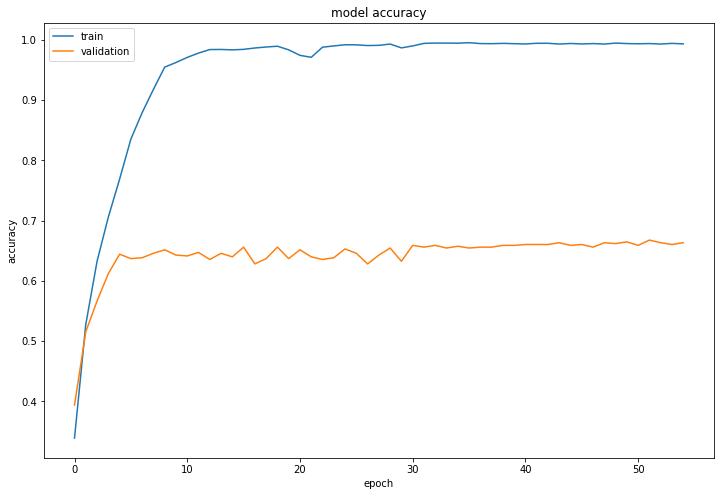

In [15]:
%matplotlib inline
vizu.plot_keras_model_learning_curve(model_lstm.history)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.77      0.49      0.60        35
          1       0.00      0.00      0.00         4
          2       0.67      0.40      0.50         5
          3       0.00      0.00      0.00         1
          4       0.80      0.73      0.76        11
          5       0.82      0.50      0.62        18
          6       0.67      0.50      0.57         4
          7       0.00      0.00      0.00         1
          8       0.94      0.68      0.79        25
          9       0.38      0.43      0.40         7
         10       0.33      0.25      0.29        12
         11       0.48      0.41      0.44        27
         12       0.18      0.50      0.26         6
         13       0.43      0.50      0.46        12
         14       0.25      0.33      0.29        42
         15       0.75      0.75      0.75         4
         16       0.50      0.33      0.40         3
         17       0.50      0.50      0.50   

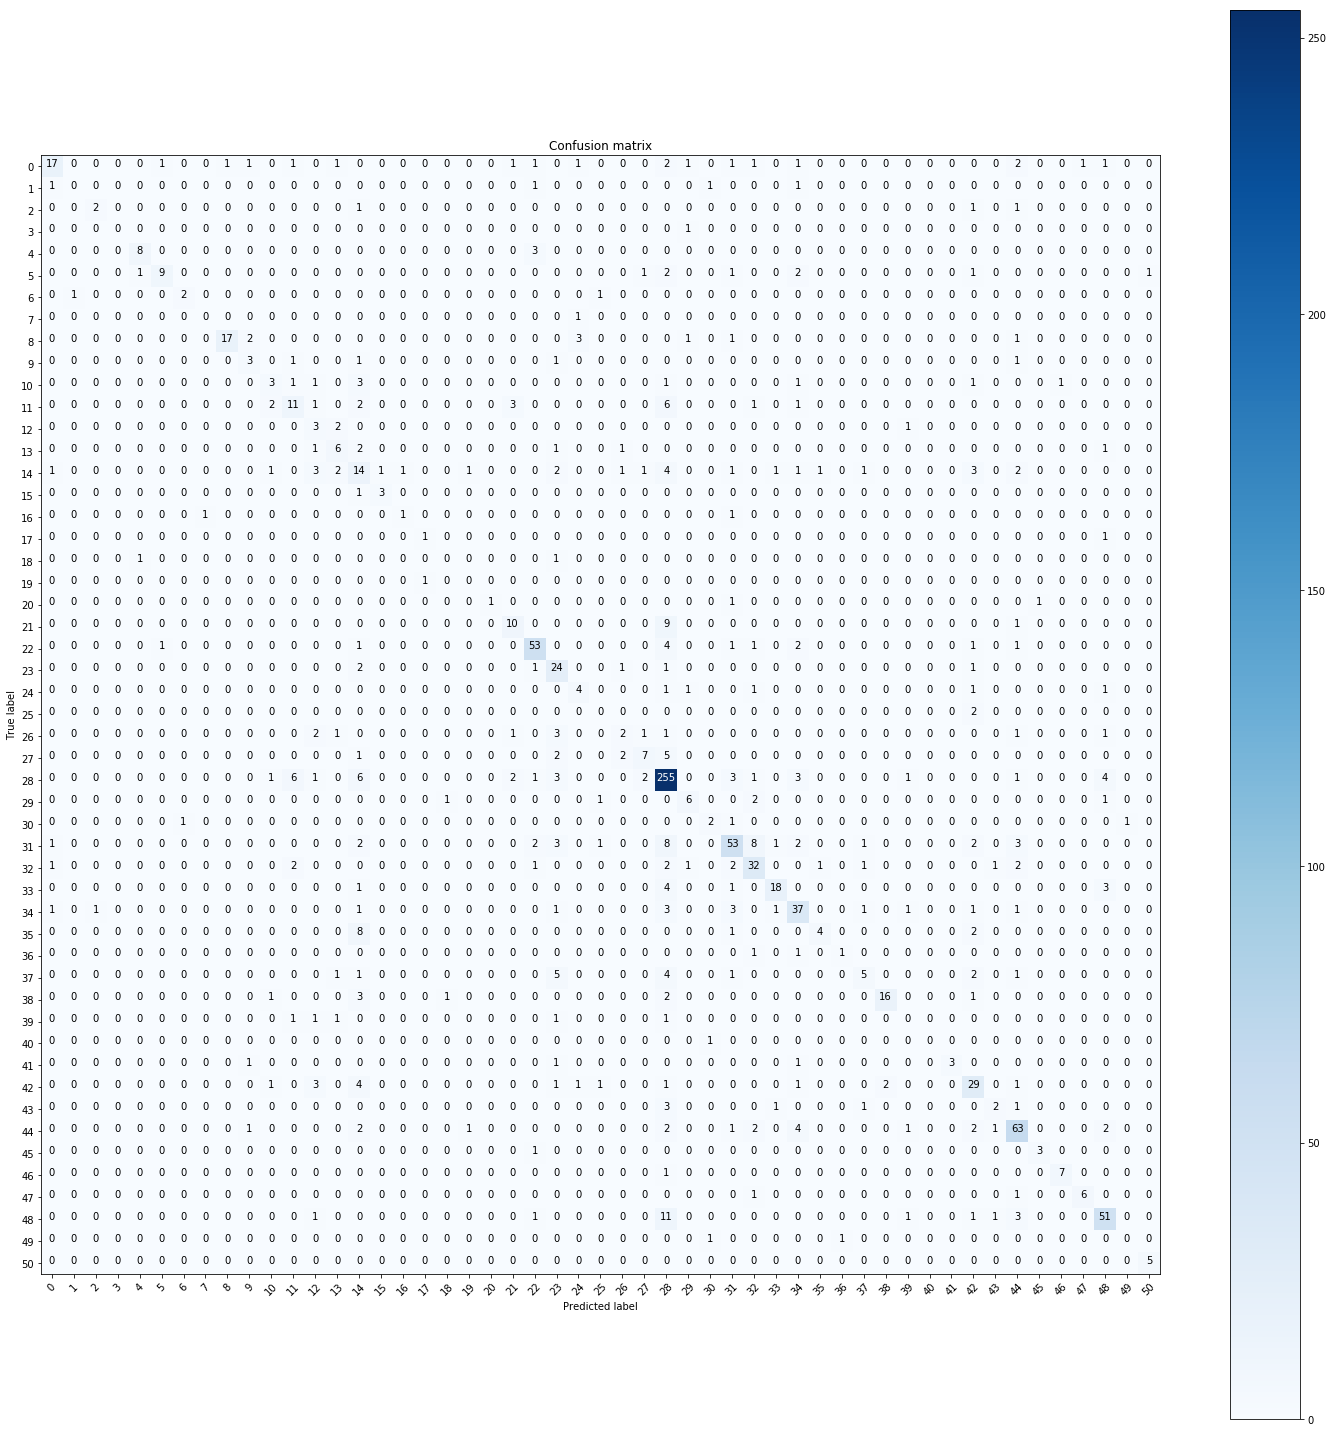

In [20]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

testSequences = tokenizer.texts_to_sequences(XTest['question'])
XEncodedTest = pad_sequences(testSequences, maxlen=sequence_length)
    
YTrue = YTest['intention']
YPredicted = model_lstm.predict_classes(XEncodedTest)
#YPredicted =list(map(lambda x : getHighProbaLabel(x), YProba))

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))
 
plt.figure(figsize=(20,20))

vizu.plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


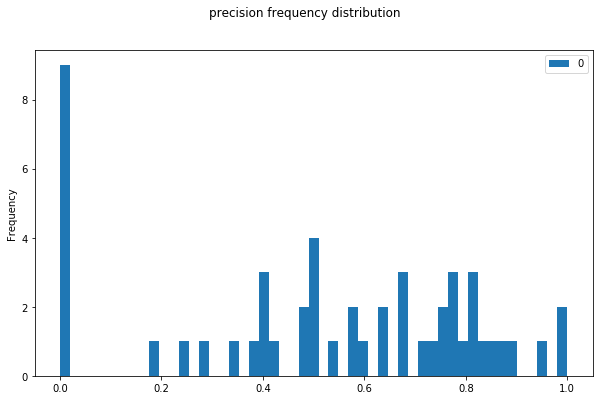

In [21]:
scores = sklearn.metrics.precision_recall_fscore_support(YTrue, YPredicted)

precision = pd.DataFrame(scores[0])
precision.plot(kind='hist',subplots=True,sharex=True,sharey=True,title='precision frequency distribution',figsize=(10,6),bins=51)
pass

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DB6030C978>],
      dtype=object)

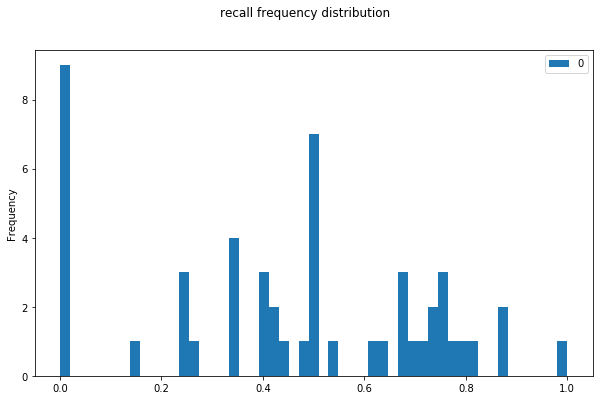

In [22]:
recall = pd.DataFrame(scores[1])
recall.plot(kind='hist',subplots=True,sharex=True,sharey=True,title='recall frequency distribution',figsize=(10,6),bins=51)


In [19]:
macroF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='macro')
microF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='micro')
print ("micro F1 score = {:1.4f} ; macro F1 score = {:1.4f}".format(microF1Score, macroF1Score))

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


micro F1 score = 0.6631 ; macro F1 score = 0.4700
